In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [2]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [3]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре"
)


# Фильтрация

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_tf", 
)

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=2000)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_tf", 
)

# Убираются слова, которые попадаются меньше чем в n процентов документов
dictionary.filter(min_df_rate=0.01)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_df_rate", 
)

# Убираются слова, которые попадаются больше чем в n процентов документов
dictionary.filter(max_df_rate=0.6)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_df_rate", 
)

  75725 - количество слов в словаре
  19855 - количество слов в словаре после фильтрации по min_tf
  19310 - количество слов в словаре после фильтрации по max_tf
   1819 - количество слов в словаре после фильтрации по min_df_rate
   1819 - количество слов в словаре после фильтрации по max_df_rate


In [4]:
def new_default_model(topic_count, dictionary):
    
    # Создание модели
    model_artm = artm.ARTM(
        # Названия тем
        topic_names=['topic_{0:0>3}'.format(i) for i in range(topic_count)], 
        # Разрешается хранить матрицу theta в памяти
        cache_theta=True,
        # Фиксация seed для воспроизвдимости результатов
        seed=-1,
        # Настройка - сколько раз обрабатывать каждый документ
        num_document_passes=1,
        # Модальности
        #class_ids={'text': 1.0},
    )

    # Инициализация модели
    model_artm.initialize(dictionary=dictionary)

    # Установка отслеживаемых параметров
    # Перплексия (чем она меньше тем лучше)
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
    # Разреженность матрицы Phi (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    # Разреженность матрицы Theta (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    # Анализ самых используемых слов по темам
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
    # Анализ ядра тем на контраст и чистоту
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
    #model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
    
    return model_artm

In [5]:
def model_print_results(model_artm):
    
    # Графики
    
    fig = plt.figure(figsize=(15, 20))

    ax = plt.subplot2grid((4,3), (0,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["PerplexityScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('PerplexityScore')
    ax.grid(True)

    ax = plt.subplot2grid((4,3), (0,1), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityPhiScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityPhiScore')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (0,2), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityThetaScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityThetaScore')
    ax.grid(True)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (1,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["TopicKernelScore"].average_contrast, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_contrast')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (1,1), colspan = 2, rowspan = 1,  fig=fig)
    my_contrast_dictionary = model_artm.score_tracker['TopicKernelScore'].last_contrast
    ax.bar(my_contrast_dictionary.keys(), my_contrast_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)


    ax = plt.subplot2grid((4,3), (2,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker['TopicKernelScore'].average_purity, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_purity')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (2,1), colspan = 2, rowspan = 1,  fig=fig)
    my_purity_dictionary = model_artm.score_tracker['TopicKernelScore'].last_purity
    ax.bar(my_purity_dictionary.keys(), my_purity_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)


    ax = plt.subplot2grid((4,3), (3,0), colspan = 1, rowspan = 1,  fig=fig)
    my_average_size = model_artm.score_tracker['TopicKernelScore'].average_size
    ax.plot(my_average_size, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(len(my_average_size))], color='tab:orange')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_size')
    ax.grid(True)
    ax.set_ylim([0,ax.get_ylim()[1]])

    ax = plt.subplot2grid((4,3), (3,1), colspan = 2, rowspan = 1,  fig=fig)
    my_size_dictionary = model_artm.score_tracker['TopicKernelScore'].last_size
    ax.bar(my_size_dictionary.keys(), my_size_dictionary.values(), 0.5, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(model_artm.num_topics)], color='tab:orange')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)

    plt.show()
    
    
    # Конечные значения
    
    print("PerplexityScore:", model_artm.score_tracker["PerplexityScore"].last_value)
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    print("TopicKernelScore_average_contrast:", model_artm.score_tracker["TopicKernelScore"].last_average_contrast)
    print("TopicKernelScore_average_purity:", model_artm.score_tracker['TopicKernelScore'].last_average_purity)
    print("TopicKernelScore_average_size:", model_artm.score_tracker['TopicKernelScore'].last_average_size)
    
    print()
    
    
    # Главные слова в темах
    
    print("TopTokensScore:")
    topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())
    for topic_name in topic_list:
        print(topic_name + ': ', end='')
        for token_name in model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]:
            print(token_name, end=' ')
        print()

In [9]:
params = {
    'topic_count': 15,
    'num_collection_passes': 20,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5,
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -3,
    },
    'DecorrelatorPhi': {
        'name': 'DecorrelatorPhi',
        'tau': 25_000_000,
    }
}

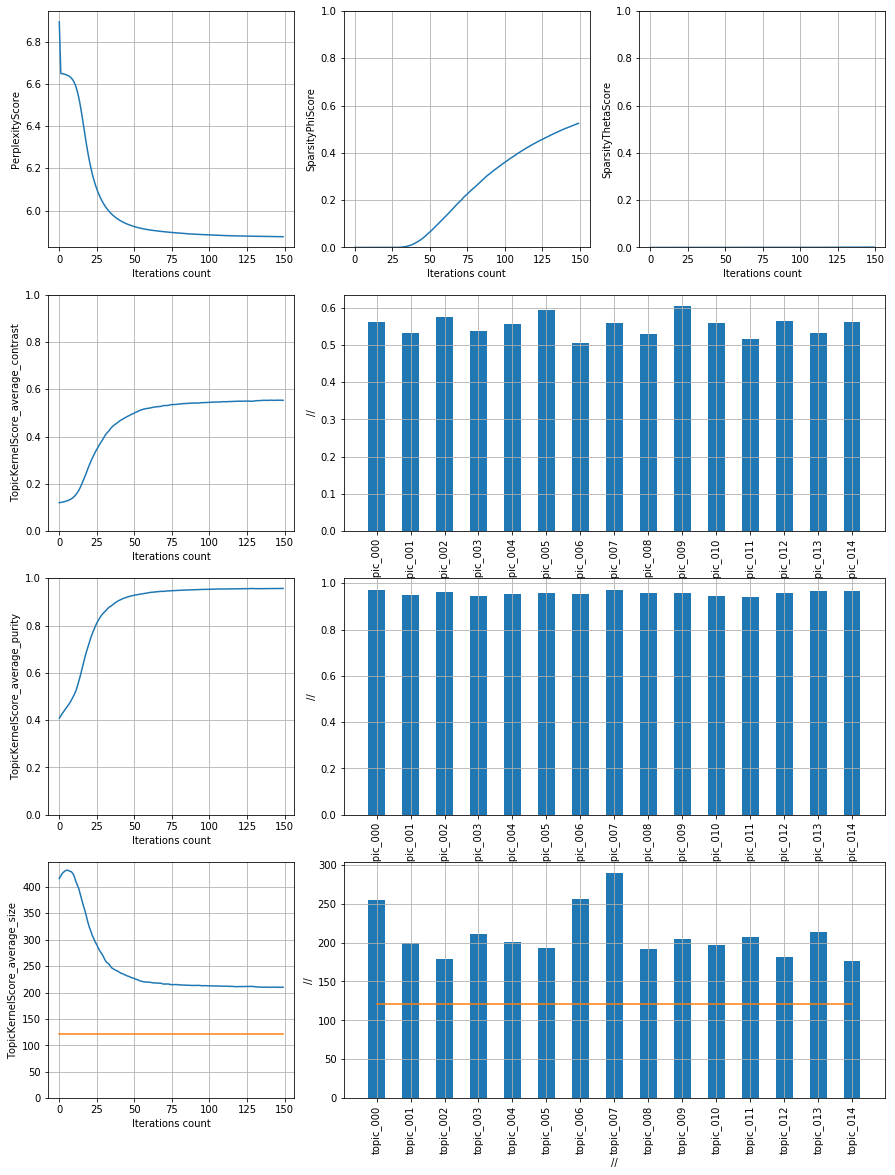

PerplexityScore: 5.876664638519287
SparsityPhiScore: 0.5249770879745483
SparsityThetaScore: 0.0013080778298899531

TopicKernelScore_average_contrast: 0.553187370300293
TopicKernelScore_average_purity: 0.9571888446807861
TopicKernelScore_average_size: 210.26666259765625

TopTokensScore:
topic_000: возможность следовать специалист любой разный высокий вывод полный необходимый поставлять 
topic_001: партия выборы открытый инфо оппозиционер оштрафовать фейсбук сторонник поддержка протест 
topic_002: служебный превышение подозревать совершенный применять кража угрожать заводить привлекать обвинительный 
topic_003: предприятие бизнесмен мошенничество особо миллион министр рабочий чиновник счет договор 
topic_004: бить взрыв вернуться предмет закрывать устройство след вещество домой позвонить 
topic_005: повреждение подросток умирать ударять скончаться тяжкий отец травма причинение девочка 
topic_006: помнить видеозапись напоминать задавать обращать читать обсуждать доказывать зачитывать огла

In [11]:
# Создание базовой пустой модели
model_artm = new_default_model(params['topic_count'], dictionary)

# Модель 0_0
# Запуск регуляризатора SparsePhi

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=150)

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_0")
model_artm_0_0 = model_artm.clone()

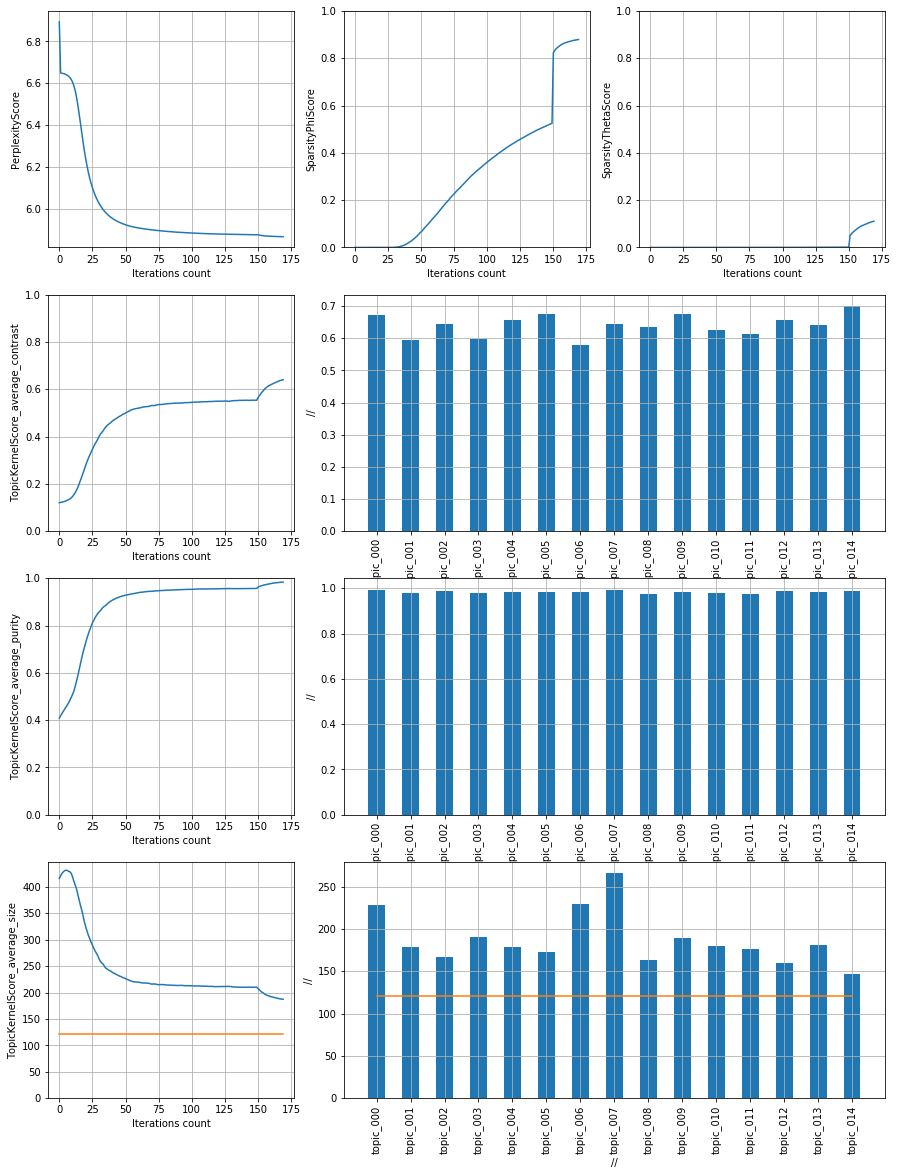

PerplexityScore: 5.867408275604248
SparsityPhiScore: 0.8797874450683594
SparsityThetaScore: 0.11126022785902023

TopicKernelScore_average_contrast: 0.6403905153274536
TopicKernelScore_average_purity: 0.9842357039451599
TopicKernelScore_average_size: 187.3333282470703

TopTokensScore:
topic_000: возможность следовать разный любой специалист полный высокий основной необходимый поставлять 
topic_001: партия открытый выборы инфо оппозиционер оштрафовать фейсбук поддержка сторонник протест 
topic_002: служебный превышение подозревать совершенный угрожать применять кража заводить привлекать обвинительный 
topic_003: предприятие бизнесмен особо мошенничество миллион министр рабочий чиновник счет договор 
topic_004: бить вернуться взрыв предмет закрывать устройство след домой вещество пакет 
topic_005: ударять отец повреждение подросток умирать скончаться тяжкий травма причинение девочка 
topic_006: помнить видеозапись напоминать задавать обращать доказывать читать обсуждать зачитывать оглашат

In [12]:
# Модель 0_1
# Запуск регуляризатора SparsePhi

# Загрузка модели
model_artm = model_artm_0_0.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора, если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_1")
model_artm_0_1 = model_artm.clone()

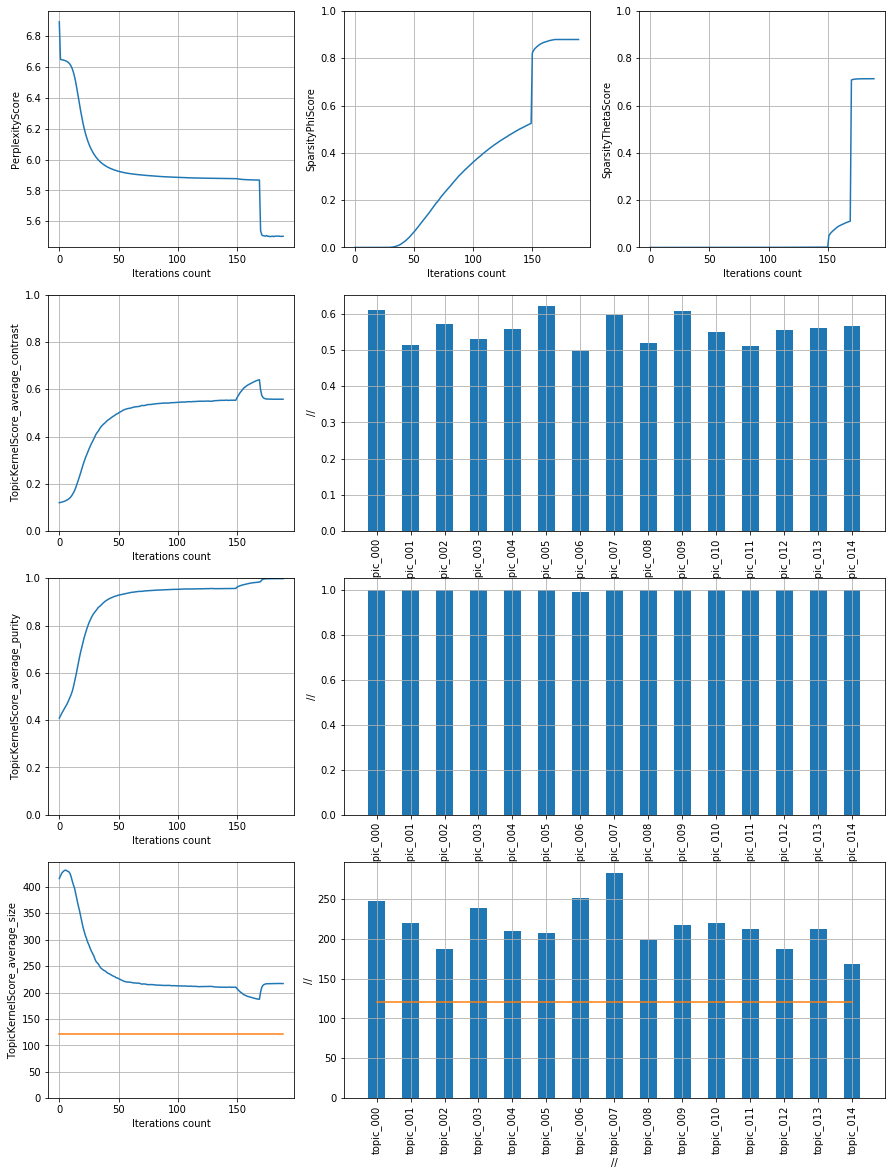

PerplexityScore: 5.503026962280273
SparsityPhiScore: 0.8798607587814331
SparsityThetaScore: 0.7139868140220642

TopicKernelScore_average_contrast: 0.5578415393829346
TopicKernelScore_average_purity: 0.9987695813179016
TopicKernelScore_average_size: 217.06666564941406

TopTokensScore:
topic_000: возможность следовать любой высокий полный специалист вывод подобный необходимый разный 
topic_001: партия выборы открытый оппозиционер инфо оштрафовать сторонник волков координатор фейсбук 
topic_002: превышение служебный кража совершенный применять подписка физический обвинительный судить признаваться 
topic_003: предприятие бизнесмен мошенничество миллион договор рабочий счет зарплата банк чиновник 
topic_004: вернуться взрыв устройство предмет след пакет вещество черный звонок комната 
topic_005: подросток повреждение ударять умирать травма девочка тяжкий причинение скончаться родитель 
topic_006: помнить задавать напоминать видеозапись читать зачитывать доказывать обсуждать оглашать пристав

In [13]:
# Модель 0_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

# Загрузка модели
model_artm = model_artm_0_1.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_2")
model_artm_0_2 = model_artm.clone()

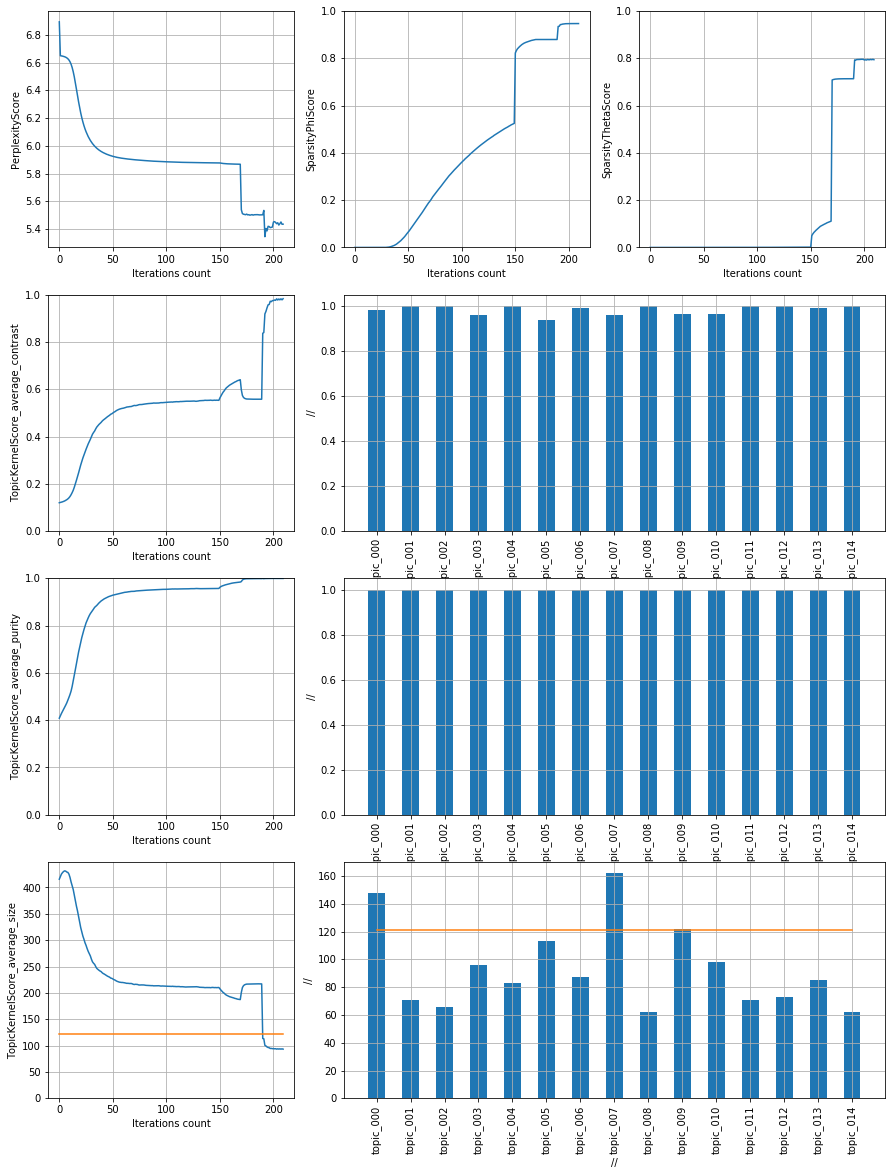

PerplexityScore: 5.43549108505249
SparsityPhiScore: 0.9472603797912598
SparsityThetaScore: 0.7943571209907532

TopicKernelScore_average_contrast: 0.9830861687660217
TopicKernelScore_average_purity: 0.9995644092559814
TopicKernelScore_average_size: 93.26667022705078

TopTokensScore:
topic_000: любой например следовать исследование высокий полный относиться подобный необходимый количество 
topic_001: партия выборы инфо оппозиционер открытый волков оштрафовать сторонник координатор политик 
topic_002: превышение служебный кража совершенный применять обвинительный подписка признаваться пытать физический 
topic_003: предприятие бизнесмен миллион мошенничество договор рабочий банк зарплата счет строительство 
topic_004: взрыв вернуться устройство предмет пакет след вещество черный звонок комната 
topic_005: подросток повреждение ударять умирать тяжкий девочка травма причинение скончаться родитель 
topic_006: помнить задавать читать напоминать зачитывать оглашать видеозапись обсуждать доказыв

In [14]:
# Модель 0_3
# Запуск регуляризатора DecorrelatorPhi к уже включенным SparsePhi, SparseTheta

# Загрузка модели
model_artm = model_artm_0_2.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Регуляризатор DecorrelatorPhi
# Создание регуляризатора если он уже не создан
if params['DecorrelatorPhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name=params['DecorrelatorPhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['DecorrelatorPhi']['name']].tau = params['DecorrelatorPhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_3")
model_artm_0_3 = model_artm.clone()

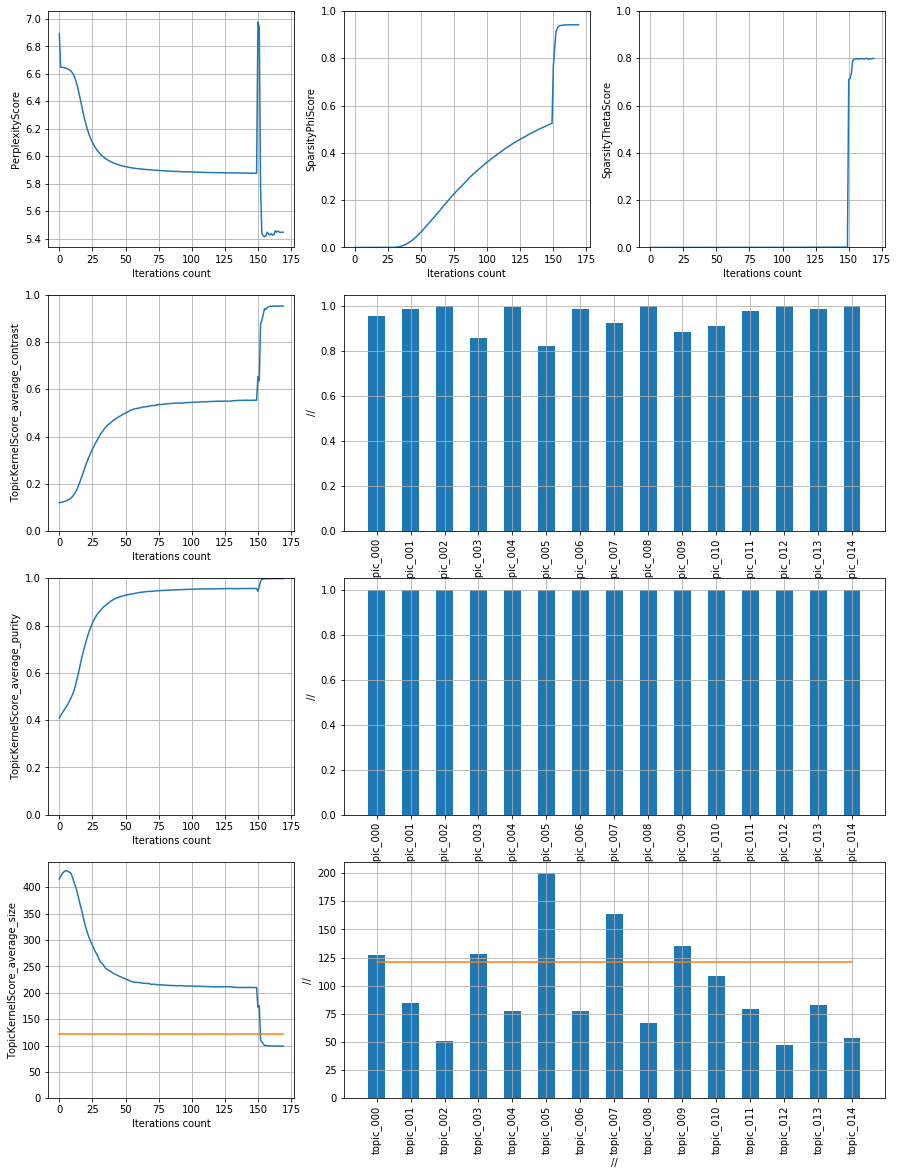

PerplexityScore: 5.4455342292785645
SparsityPhiScore: 0.9423125982284546
SparsityThetaScore: 0.7993544340133667

TopicKernelScore_average_contrast: 0.9523323178291321
TopicKernelScore_average_purity: 0.9990028738975525
TopicKernelScore_average_size: 99.0

TopTokensScore:
topic_000: возможность специалист любой следовать исследование высокий иной поставлять полный подобный 
topic_001: партия выборы оппозиционер удаваться инфо протест сторонник волков политик оштрафовать 
topic_002: превышение кража похищать пытать татарстан признаваться судить казань похищение сексуальный 
topic_003: предприятие бизнесмен особо мошенничество миллион договор министр счет зарплата рабочий 
topic_004: бить вернуться позвонить устройство звонок черный пакет комната домой магазин 
topic_005: подросток повреждение отец ударять умирать тяжкий травма скончаться причинение девочка 
topic_006: помнить задавать читать зачитывать оглашать никита перерыв обращать переходить осмотр 
topic_007: вспоминать сидеть нужно

In [15]:
# Альтернативная модель 1_0
# Запуск одновременно 3 регуляризаторов SparsePhi, SparseTheta, DecorrelatorPhi

# Загрузка модели
model_artm = model_artm_0_0.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Регуляризатор DecorrelatorPhi
# Создание регуляризатора если он уже не создан
if params['DecorrelatorPhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name=params['DecorrelatorPhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['DecorrelatorPhi']['name']].tau = params['DecorrelatorPhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_1_0")
model_artm_1_0 = model_artm.clone()

In [16]:
phi = model_artm.phi_
phi

,topic_000,topic_001,topic_002,topic_003,topic_004,topic_005,topic_006,topic_007,topic_008,topic_009,topic_010,topic_011,topic_012,topic_013,topic_014
семейный,0.000000,0.000000,0.0,0.000000,0.000000,0.001752,0.000000,0.000804,0.000000,0.000000,0.000000,0.0,0.000000,0.000792,0.000000
жительница,0.000000,0.000000,0.0,0.000000,0.000000,0.008798,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
взыскание,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.009577,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
сокращать,0.000000,0.000000,0.0,0.005577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
вменять,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
объединение,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
памятник,0.000000,0.010332,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
дежурный,0.000000,0.000000,0.0,0.000000,0.000000,0.008442,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
готовый,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
столкновение,0.000000,0.000000,0.0,0.000000,0.000000,0.000506,0.000000,0.000000,0.000000,0.005266,0.000000,0.0,0.000000,0.000000,0.000000


In [17]:
theta = model_artm.get_theta()
theta

,9000,9001,9002,9003,9004,9005,9006,9007,9008,9009,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
topic_000,0.056862,0.064605,0.037001,3.517622e-03,0.068741,0.178901,0.027465,0.017952,0.054058,0.030761,...,0.082785,6.958145e-02,2.253438e-06,1.894057e-06,0.058931,0.043625,0.060164,0.061185,0.026179,0.036052
topic_001,0.024736,0.073257,0.042837,9.820991e-03,0.489061,0.008331,0.029409,0.003159,0.151610,0.082734,...,0.087428,4.981866e-02,1.921895e-01,5.540452e-03,0.276111,0.032726,0.016921,0.123529,0.040259,0.246644
topic_002,0.014694,0.117575,0.027533,8.600535e-02,0.009064,0.035588,0.000067,0.294145,0.011156,0.010832,...,0.004510,8.007609e-04,4.579893e-02,6.609563e-02,0.012820,0.072132,0.074581,0.000638,0.043570,0.080548
topic_003,0.021153,0.015325,0.036757,7.350261e-03,0.024624,0.021152,0.001594,0.098966,0.034804,0.006235,...,0.068271,4.761118e-02,3.679267e-03,8.969214e-03,0.020045,0.042087,0.014852,0.222365,0.466534,0.125626
topic_004,0.083079,0.041541,0.089341,1.631773e-01,0.000473,0.040581,0.126141,0.078511,0.038495,0.039691,...,0.005295,1.776073e-02,2.140796e-04,9.165384e-02,0.142234,0.000003,0.041600,0.107687,0.035695,0.002236
topic_005,0.105865,0.028672,0.063400,3.997161e-01,0.002788,0.033571,0.180592,0.119920,0.005939,0.019458,...,0.287103,3.254821e-01,8.832548e-02,1.777365e-02,0.011624,0.012528,0.130000,0.047910,0.005638,0.025890
topic_006,0.090709,0.059820,0.104321,1.090824e-14,0.086847,0.070264,0.066407,0.040862,0.052914,0.050613,...,0.003470,3.928673e-07,2.458935e-09,1.421012e-02,0.065608,0.005218,0.043185,0.021149,0.009270,0.026285
topic_007,0.028816,0.012213,0.056478,2.274038e-02,0.045272,0.200520,0.133925,0.128281,0.077008,0.037953,...,0.021205,1.912550e-02,1.315632e-12,7.661774e-04,0.113707,0.030497,0.010558,0.012125,0.013623,0.045088
topic_008,0.197014,0.055448,0.211683,1.847666e-01,0.004724,0.037591,0.043504,0.013376,0.082262,0.132311,...,0.006240,4.143610e-02,3.884464e-02,2.643753e-02,0.054998,0.083420,0.013876,0.130686,0.023204,0.019760
topic_009,0.212222,0.019374,0.137847,1.183332e-02,0.038123,0.057374,0.145313,0.066514,0.002866,0.000064,...,0.252667,3.321531e-01,4.054733e-01,1.978316e-02,0.088473,0.114037,0.239952,0.023038,0.068437,0.028438
